In [1]:
import pandas as pd
import numpy as np
import catboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from itertools import chain, combinations
from scipy.special import softmax

from tqdm import tqdm
from warnings import filterwarnings
from IPython.display import display

filterwarnings("ignore")
pd.set_option('display.max_columns', None)
np.random.seed(42)

In [2]:
class ModelBuilderUtils(object):
    def __init__(self):
        self.metrics = {"MAE": [], "RMSE": [], "MAPE": [], "R2": []}  # init metrics dict

    def load_data(self, path: str = "./data/BST_DataSet.xlsx"):
        # load the date and parse dates
        df = pd.read_excel(path, parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')

        # create cols encoding fwd and bwd
        self.columns_to_nums = dict(zip(df.columns, np.arange(len(df.columns), dtype=int)))
        self.nums_to_columns = dict(zip(np.arange(len(df.columns), dtype=int), df.columns))

        # rename cols
        df = df.rename(columns=self.columns_to_nums, inplace=False)

        # rename "0" back to target
        df['target'] = df[0]
        df = df.drop([0], axis=1, inplace=False)

        return df

    def split_df(self, df):
        # split the data
        df_train = df[df.index < '2017-01-01']
        df_test = df[df.index >= '2017-01-01']
        return df_train, df_test

    def score_model(self, y_trues, y_preds):
        # create scores
        self.metrics["MAE"].append(int(mean_absolute_error(y_trues, y_preds)))
        self.metrics["MAPE"].append(mean_absolute_percentage_error(y_trues, y_preds))
        self.metrics["RMSE"].append(int(mean_squared_error(y_trues, y_preds, squared=False)))
        self.metrics["R2"].append(r2_score(y_trues, y_preds))

    def display_predictions(self, timeseries, predict):
        # display predictions
        plt.figure(dpi=150)
        plt.figure(figsize=(16, 6))
        plt.grid()
        plt.plot(timeseries, color="blue", label="true")
        plt.plot(predict, color="green", label="predictions")
        plt.legend(loc="upper left")
        plt.show()

    def choose_cols(self, df, cols):
        return df.loc[:, cols]

    def get_subsets(self, ss):
        return chain(*map(lambda x: combinations(ss, x), range(0, len(ss) + 1)))

    def feature_importance(self, model):
        fi = softmax(model.get_feature_importance()[3:])
        cols = list(self.nums_to_columns.values())[1:]
        pd.DataFrame([fi], columns=cols, index=np.arange(len(cols), dtype=int)).iloc[0, :].to_csv(
            "./output/feature_importance.csv")

    # to implement
    def save_model(self, path: str = "./model.pth"):
        pass

    # to implement
    def load_model(self, path: str = "./model.pth"):
        pass


In [3]:
class ModelBuilderFeatureExtractor:
    def __init__(self):
        self.window = None  # window for MA and strides; instantiated in ModelBuilder
        self.monthly_mean = None  # df with monthly_mean

    def enreach_data_1(self, df):
        # append monthly_mean and monthly_sin to df
        df['monthly_mean'] = df.groupby(df.index.month)['target'].transform(np.mean)
        df['monthly_sin'] = list(map(lambda x: np.sin(x / 3.82), df.index.month))
        return df

    def enreach_data_2(self, df_train, window: int = 8):
        # calculate rolling mean
        df_rolling = df_train.rolling(window).mean()  # removed closed="left"

        # set names for new dfs
        df_rolling.columns = list(map(lambda x: "rolling_mean_" + str(x), df_train.columns))

        # fill in the missing
        df_rolling.to_numpy()[:window] = self.monthly_mean.to_numpy()[:window]

        # drop rolling_mean_target
        df_rolling = df_rolling.drop(['rolling_mean_target'], axis=1, inplace=False)

        # concat with the df_train
        return pd.merge(df_train, df_rolling, left_index=True, right_index=True)

    def extract_monthly_mean(self, df_train):
        # calculate monthly by month; USE IT ON TRAIN
        tmp = pd.DataFrame.copy(df_train)
        tmp['month'] = tmp.index.month
        preds_by_month = tmp.groupby(['month']).mean()

        # stores result in var
        self.monthly_mean = pd.DataFrame.copy(preds_by_month)

    def select_period(self, df_train, model_idx):
        # selects period for transformation
        return df_train[-(self.window + model_idx):].values

    def extract_window(self, X, idx):
        """
        1. extract features from df into matrix (n, m, q);
        q – number of features, m – idx + window, n – function of m and q

        2. reshapes into (n, m * q) – matrix
        :param X:
        :param idx:
        :return:
        """

        # don't forget to [:-1]
        X = np.apply_along_axis(
            lambda x: np.lib.stride_tricks.sliding_window_view(x, window_shape=(idx + self.window)), arr=X,
            axis=0)[:-1]

        X = np.reshape(X, newshape=(X.shape[0], X.shape[1] * X.shape[2]), order='F')
        return X

    def generate_new_df(self, df_test, predict, idx):
        # generates new df for predict
        index = df_test.index[idx]
        df = df_test.loc[[index]]
        df['target'] = [predict]
        return df

In [4]:
class ModelBuilder(ModelBuilderUtils, ModelBuilderFeatureExtractor):
    def __init__(self, window: int = 8, model_count: int = 12):
        super().__init__()

        self.window = window  # window for MA and strides
        self.model_count = model_count  # number of days to predict
        self.df_test = None  #other features MA
        self.metrics = {"MAE": [], "RMSE": [], "MAPE": [], "R2": []}  # init metrics dict

    def build_datasets(self, df_train, df_test):

        # creates var; features for test predictions will be taken from here
        self.df_test = pd.DataFrame.copy(df_test)

        # list to store models
        datasets = [float('inf')] * self.model_count
        for i in range(self.model_count):
            # generates feature-sample matrix for X
            X = self.extract_window(df_train, i)

            # extracts
            y = df_train[i + self.window:]['target']

            # appends to ds
            datasets[i] = (X, y)

        assert len(datasets) == self.model_count

        return datasets

    def train_models(self, datasets):

        # trains models; uses catboost
        models = [float('inf')] * self.model_count
        for i in tqdm(range(self.model_count)):
            model = catboost.CatBoostRegressor(n_estimators=100, verbose=False, allow_writing_files=False,
                                               loss_function='RMSE')
            model.fit(*datasets[i])
            models[i] = model

        assert len(models) == len(datasets)

        return models

    def predict(self, df_train, models):  # requiers df_train to be passed in
        for i in range(self.model_count):
            # select period to extract features from
            table = self.select_period(df_train, i)
            # flatten features
            row = np.reshape(table, newshape=(1, table.size), order='F').squeeze()
            # predicts next value => predict: float
            predict = models[i].predict(row)
            # generates new df (using df_test with precalculated features and new_predict)
            df_predict = self.generate_new_df(self.df_test, predict, i)
            # appends new sample to df
            df_train = pd.concat([df_train, df_predict])
            # process repeats

        # returns predictions
        return df_train[-self.model_count:]['target']

100%|██████████| 12/12 [00:00<00:00, 12.50it/s]


<Figure size 900x600 with 0 Axes>

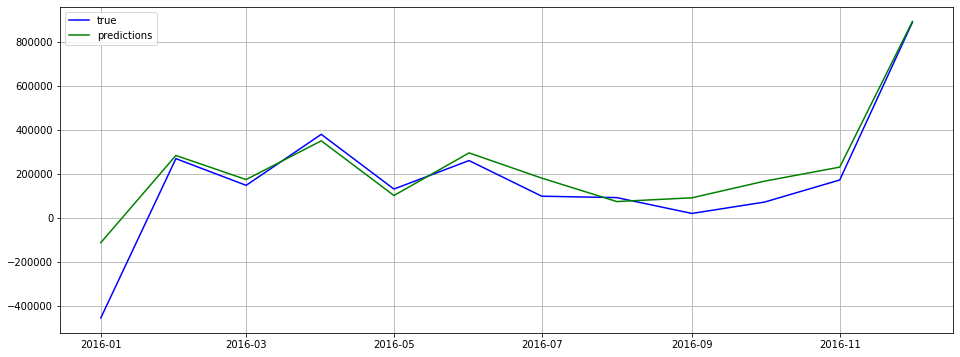

,MAE,RMSE,MAPE,R2
0,67055,110106,0.634416,0.856608


In [9]:
class Model(ModelBuilder):

    def __init__(self):
        super().__init__()

    def pipeline(self, inference=False):
        # load the data
        df = self.load_data()

        # split the data
        df_train, df_test = self.split_df(df)

        # creates self.monthly_mean on df_train; MUST BE DONE
        self.extract_monthly_mean(df_train)

        # en-reach_1 the data with monthly_mean and month
        df_train = self.enreach_data_1(df_train)
        df_test = self.enreach_data_1(df_test)

        # en-reach_2 the data with the rolling mean for all cols except of target;
        # doesn't seem to work: reason –> small df

        # df_train = self.enreach_data_rm(df_)
        # df_test = self.enreach_data_rm(df_test)

        # choose necessary columns
        # interesting cols: 3, 4, 5, 6, 10
        cols = ['target', 'monthly_mean',
                "monthly_sin"]

        # cols = cols + list(np.arange(1, 11, dtype=int))  # enable for feature importance check
        cols = cols + [1]  # cols to train

        df_train = self.choose_cols(df_train, cols)
        df_test = self.choose_cols(df_test, cols)
        ModelBuilder.__init__(self, window=8, model_count=12)

        # chose window size

        # if not inference, recreate df_train / df_test datasets
        if not inference:
            _ = pd.DataFrame.copy(df_train)
            df_train = pd.DataFrame.copy(_[:-self.model_count])
            df_test = pd.DataFrame.copy(_[-self.model_count:])

        # create datasets, train models, get predictions
        datasets = self.build_datasets(df_train, df_test)
        models = self.train_models(datasets)
        preds = round(self.predict(df_train, models))

        # extract feature importance:
        # self.feature_importance(models[0])

        # display if on inference and save predictions
        if inference:
            self.display_predictions(df_train['target'], preds)
            preds.to_csv("./output/predictions.csv", index=True)

        # display if not on inference and show metrics
        if not inference:
            self.score_model(df_test['target'], preds)
            self.display_predictions(df_test['target'], preds)
            display(pd.DataFrame(self.metrics, index=[0]))

    def main(self, inference=False):
        self.pipeline(inference)


# create the model
model = Model()

# run the model
model.main(inference=False)

100%|██████████| 12/12 [00:01<00:00, 11.70it/s]


<Figure size 900x600 with 0 Axes>

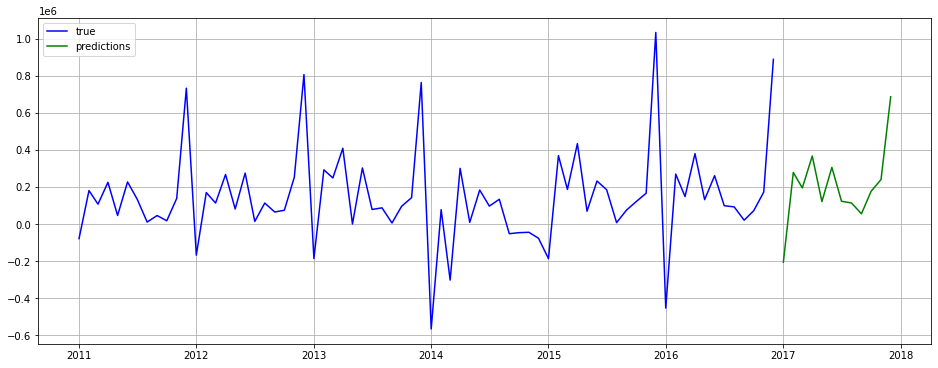

In [6]:
model.main(inference=True)